# Predicting Term Sheet Purchase

#### Model Buidling Steps

- 
- 
- 
- 
- 
- 
- 

#### References

- https://stackoverflow.com/questions/46062679/right-order-of-doing-feature-selection-pca-and-normalization

- https://towardsdatascience.com/preventing-data-leakage-in-your-machine-learning-model-9ae54b3cd1fb

- https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/

- https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

- https://stats.stackexchange.com/questions/363548/use-of-smote-with-training-test-and-dev-sets

- https://datascience.stackexchange.com/questions/27615/should-we-apply-normalization-to-test-data-as-well

> Import analysis and visualization libraires

In [449]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype

> Import dataset

- drop duration column (directly impacts the target varible and not good for modelling)

In [450]:
path= '../../datasets/main_data/bank-additional-full.csv'
full_bank = pd.read_csv(path, sep=';')

In [451]:
full_bank.shape

(41188, 21)

In [452]:
full_bank.drop('duration', axis=1, inplace=True)

In [453]:
full_bank.shape

(41188, 20)

> import project-defined modules

In [454]:
from plot import plot_univariate, plot_bivariate
from data import check_outliers, treat_outliers

> Import preprocessing libraries

In [455]:
from sklearn.preprocessing import StandardScaler,RobustScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from imblearn.over_sampling import SMOTE, _random_over_sampler
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif, from_model, SelectKBest,chi2, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest # outlier detection and re,oval
from collections import Counter

> Import estimator libraries

In [456]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
import xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

> Import libraries for measuring model perofrmance

In [457]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate

> Import production libraries

In [458]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
import joblib

#### Data Preprocessing

In [459]:
full_bank

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [460]:
full_bank.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [461]:
full_bank.isna().any()

age               False
job               False
marital           False
education         False
default           False
housing           False
loan              False
contact           False
month             False
day_of_week       False
campaign          False
pdays             False
previous          False
poutcome          False
emp.var.rate      False
cons.price.idx    False
cons.conf.idx     False
euribor3m         False
nr.employed       False
y                 False
dtype: bool

#### Outlier Detection and Treatment

> check for outliers

In [462]:
check_outliers(full_bank)

,age,campaign,pdays,previous,cons.conf.idx
0,56,1,999,0,-36.4
1,57,1,999,0,-36.4
2,37,1,999,0,-36.4
3,40,1,999,0,-36.4
4,56,1,999,0,-36.4
...,...,...,...,...,...
41183,73,1,999,0,-50.8
41184,46,1,999,0,-50.8
41185,56,2,999,0,-50.8
41186,44,1,999,0,-50.8


> treat outliers

In [463]:
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(full_bank.select_dtypes(exclude='object'))
# select all rows that are not outliers
mask = yhat != -1 
clean_df1 = full_bank[mask]
# summarize the shape of the updated training dataset
print(clean_df1.shape)

(37069, 20)


In [464]:
clean_df1

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40541,30,admin.,single,university.degree,no,yes,no,cellular,aug,tue,1,999,0,nonexistent,-1.7,94.027,-38.3,0.886,4991.6,no
40542,30,admin.,single,university.degree,no,no,no,cellular,aug,tue,1,999,0,nonexistent,-1.7,94.027,-38.3,0.886,4991.6,yes
40549,58,retired,divorced,basic.4y,no,no,no,telephone,aug,tue,1,999,0,nonexistent,-1.7,94.027,-38.3,0.886,4991.6,no
40550,34,blue-collar,married,basic.9y,no,yes,no,cellular,aug,tue,2,999,0,nonexistent,-1.7,94.027,-38.3,0.886,4991.6,no


#### Now let's check for class imbalance

Text(0.7, 30000, "Class Imbalance Count:\n\n{'no': 34188, 'yes': 2881}")

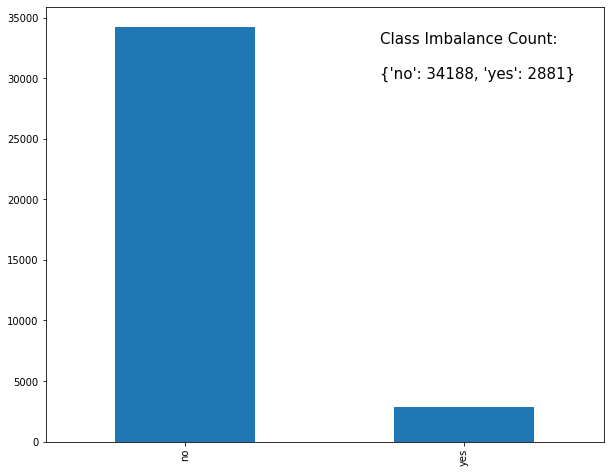

In [465]:
plt.subplots(figsize=(10,8))
clean_df1['y'].value_counts().plot(kind='bar')
plt.text(x=0.7, y=30000, s=f'Class Imbalance Count:\n\n{clean_df1.y.value_counts().to_dict()}', fontsize=15)

> We have a very high class imbalance

> This would be dealt with after splitting out data to train and test and applied only to train to avoid data leakage

#### split data

> Beofore further preprocessing, it is important we split the data into train and test set to avoid `data leakage`

In [466]:
features, target = clean_df1.drop('y', axis=1), pd.DataFrame(clean_df1['y'])

#### encode categorical variables

In [467]:
def encode (data):
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore', )
    to_encode = data.select_dtypes(exclude='number')
    if data.shape[1] > 1:
        #ohe = MultiLabelBinarizer()
        data.drop(to_encode.columns.tolist(), axis=1, inplace = True)
        features_cat_encode = pd.DataFrame(ohe.fit_transform(to_encode))
        data = data.merge(features_cat_encode, left_index=True, right_index=True)
        #print(ohe.classes_) 
    else:
        data = pd.DataFrame(ohe.fit_transform(to_encode))
        print(ohe.categories_) 
    return data 

In [468]:
features = encode(features)
features

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,0,...,42,43,44,45,46,47,48,49,50,51
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37062,43,1,999,0,-2.9,92.469,-33.6,1.029,5076.2,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
37063,42,1,999,0,-2.9,92.469,-33.6,1.029,5076.2,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
37064,42,1,999,0,-2.9,92.469,-33.6,1.029,5076.2,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
37065,32,1,999,0,-2.9,92.469,-33.6,1.029,5076.2,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [469]:
target = encode(target)

[array(['no', 'yes'], dtype=object)]


In [470]:
target

,0,1
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
...,...,...
37064,1.0,0.0
37065,0.0,1.0
37066,1.0,0.0
37067,1.0,0.0


> make shape equal

In [471]:
target=target.iloc[0:features.shape[0]]

In [472]:
target

,0,1
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
...,...,...
36356,1.0,0.0
36357,1.0,0.0
36358,1.0,0.0
36359,1.0,0.0


> trim target varibles `purchase` to a single column of `yes`

In [473]:
target.drop(0, axis=1, inplace=True)

/home/patrick/.local/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [474]:
target

,1
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
36356,0.0
36357,0.0
36358,0.0
36359,0.0


In [475]:
X_train, X_test, y_train, y_test = train_test_split(features, target,
                                               test_size=.10, random_state=1234)

In [476]:
X_train

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,0,...,42,43,44,45,46,47,48,49,50,51
8744,35,1,999,0,1.4,94.465,-41.8,4.866,5228.1,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
19184,59,2,999,0,1.4,93.444,-36.1,4.968,5228.1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
34881,51,1,999,0,-1.8,92.893,-46.2,1.250,5099.1,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2314,33,6,999,0,1.1,93.994,-36.4,4.856,5191.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
16253,25,5,999,0,1.4,93.918,-42.7,4.961,5228.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32916,30,1,999,0,-1.8,92.893,-46.2,1.299,5099.1,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
17236,51,3,999,0,1.4,93.918,-42.7,4.962,5228.1,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
24212,49,1,999,0,-0.1,93.200,-42.0,4.191,5195.8,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
34621,28,2,999,0,-1.8,92.893,-46.2,1.266,5099.1,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [477]:
y_train

,1
8679,0.0
18929,0.0
34343,0.0
2314,0.0
16071,1.0
...,...
32399,0.0
17048,0.0
23924,0.0
34086,0.0


#### Deal with class imbalance

In [478]:
y_train[1].value_counts()

0.0    30410
1.0     2314
Name: 1, dtype: int64

> Since we have an imbalance case of very high majority vs very low minority,

> a good decision would be to use the SMOTE technique of oversampling the minority to mathc the majority class

In [479]:
oversample = SMOTE(random_state=1234)
X_train, y_train = oversample.fit_sample(X_train, y_train)

In [480]:
X_train

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,0,...,42,43,44,45,46,47,48,49,50,51
0,35,1,999,0,1.4,94.465,-41.8,4.866000,5228.1,0.000000,...,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,1.0,0.0
1,59,2,999,0,1.4,93.444,-36.1,4.968000,5228.1,1.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.0,0.0
2,51,1,999,0,-1.8,92.893,-46.2,1.250000,5099.1,1.000000,...,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0
3,33,6,999,0,1.1,93.994,-36.4,4.856000,5191.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,1.0,0.0
4,25,5,999,0,1.4,93.918,-42.7,4.961000,5228.1,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60815,51,3,999,0,1.1,93.994,-36.4,4.858799,5191.0,0.899286,...,0.0,0.0,0.000000,0.100714,0.000000,0.000000,0.899286,0.0,1.0,0.0
60816,43,2,999,0,1.4,93.444,-36.1,4.968000,5228.1,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.0,0.0
60817,49,6,999,0,-2.9,92.963,-40.8,1.271895,5076.2,0.000000,...,0.0,0.0,0.299616,0.700384,0.000000,0.000000,0.000000,0.0,1.0,0.0
60818,53,2,999,0,1.4,93.918,-42.7,4.961562,5228.1,0.718884,...,0.0,0.0,0.281116,0.000000,0.000000,0.718884,0.000000,0.0,1.0,0.0


In [481]:
y_train

,1
0,0.0
1,0.0
2,0.0
3,0.0
4,1.0
...,...
60815,1.0
60816,1.0
60817,1.0
60818,1.0


> compare the class distribution

In [482]:
trains = pd.merge(X_train, y_train, left_index=True, right_index=True)

In [483]:
trains

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,0,...,43,44,45,46,47,48,49,50,51,1_y
0,35,1,999,0,1.4,94.465,-41.8,4.866000,5228.1,0.000000,...,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,1.0,0.0,0.0
1,59,2,999,0,1.4,93.444,-36.1,4.968000,5228.1,1.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.0,0.0,0.0
2,51,1,999,0,-1.8,92.893,-46.2,1.250000,5099.1,1.000000,...,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0
3,33,6,999,0,1.1,93.994,-36.4,4.856000,5191.0,0.000000,...,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,1.0,0.0,0.0
4,25,5,999,0,1.4,93.918,-42.7,4.961000,5228.1,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60815,51,3,999,0,1.1,93.994,-36.4,4.858799,5191.0,0.899286,...,0.0,0.000000,0.100714,0.000000,0.000000,0.899286,0.0,1.0,0.0,1.0
60816,43,2,999,0,1.4,93.444,-36.1,4.968000,5228.1,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.0,0.0,1.0
60817,49,6,999,0,-2.9,92.963,-40.8,1.271895,5076.2,0.000000,...,0.0,0.299616,0.700384,0.000000,0.000000,0.000000,0.0,1.0,0.0,1.0
60818,53,2,999,0,1.4,93.918,-42.7,4.961562,5228.1,0.718884,...,0.0,0.281116,0.000000,0.000000,0.718884,0.000000,0.0,1.0,0.0,1.0


In [484]:
trains_class = trains['1_y'].value_counts().to_dict() 
trains_class

{1.0: 30410, 0.0: 30410}

Text(0.2, 30000, 'Class Imbalance Count:\n\n{1.0: 30410, 0.0: 30410}')

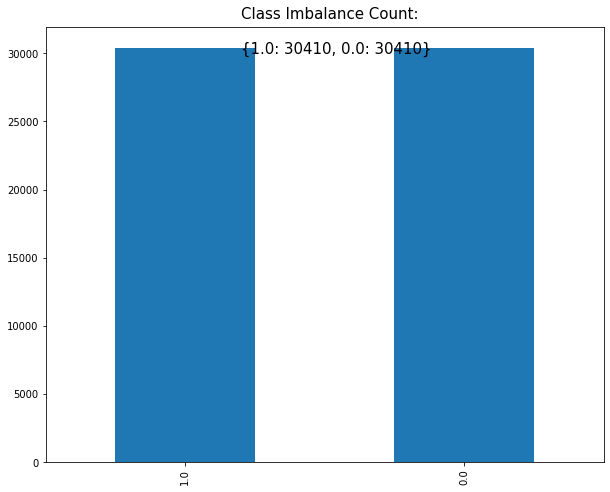

In [485]:
plt.subplots(figsize=(10,8))
trains['1_y'].value_counts().plot(kind='bar')
plt.text(x=0.2, y=30000, s=f'Class Imbalance Count:\n\n{trains_class}', fontsize=15)

> We now have a balanced class and can go on to further preprocess

#### Normalize X_train and X_test datasets

> I would be using the RobustScaler which is less prone to outliers

In [486]:
scaler = RobustScaler()
scaler

RobustScaler()

In [487]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [488]:
X_train_scaled

array([[-0.13333333, -0.5       ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.46666667,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.93333333, -0.5       ,  0.        , ...,  1.        ,
        -1.        ,  0.        ],
       ...,
       [ 0.8       ,  2.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.06666667,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.53333333, -0.5       ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [489]:
X_test_scaled

array([[ 0.13333333, -0.5       ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.93333333,  0.5       ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.6       ,  0.5       ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.2       ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.46666667,  0.5       ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [490]:
Y_train = scaler.fit_transform(Y_train)

In [491]:
Y_train

array([[-0.5],
       [-0.5],
       [-0.5],
       ...,
       [ 0.5],
       [ 0.5],
       [ 0.5]])

In [492]:
pd.DataFrame(Y_train)[0].value_counts()

 0.5    30319
-0.5    30319
Name: 0, dtype: int64

#### Dimensionality Reduction

> RIght now, our input variables are quite large, which has potential of affecting our prediciton

> To optimise the predictive features of our variables and save memory space on the model,

> we can reduce the number of features using PCA

First let's plot the number of components we need to get the most explained variance of our data

- Xtrain

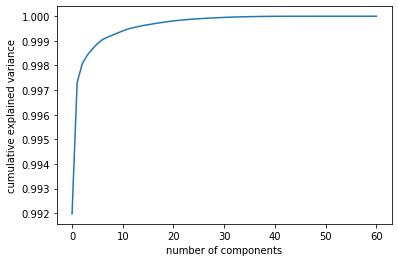

In [493]:
pca = PCA().fit(X_train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

From the plot above, we can see that we need up to 50 components to get an high explained variance

> This means whar we need for our prediction is feature extraction  and not feature reduction

In [401]:
pca = PCA(50, random_state=1234)  # project from 64 to 2 dimensions
X_train_reduced = pca.fit_transform(X_train_scaled)
X_test_reduced = pca.fit_transform(X_test_scaled)
print(X_train_reduced.shape) 
print(x_test_reduced.shape)

(61062, 50)
(3623, 50)


In [402]:
X_train_reduced

array([[ 2.62453053e+00,  1.26011183e+00,  5.82374638e-01, ...,
         3.90694360e-02, -3.69288110e-02,  1.34716669e-02],
       [-1.14995310e+00, -2.82088447e+00,  1.31848691e+00, ...,
        -4.98387748e-02,  6.02262409e-03, -1.65773452e-03],
       [-2.60712649e+00, -4.66719718e-01, -7.43561008e-02, ...,
         1.92141665e-01,  8.36132977e-03,  5.91687682e-03],
       ...,
       [ 1.58986365e+00, -1.62046214e+00,  1.04329357e+00, ...,
         5.50848485e-01, -2.94100042e-01,  7.33442478e-02],
       [-1.63866712e+00,  1.40109600e+00,  1.66329597e+00, ...,
         1.33950501e-03,  8.08532356e-03, -1.48657247e-02],
       [-4.45032445e-01, -7.97033884e-01, -8.39791805e-01, ...,
        -5.19586178e-01,  2.12410245e-01,  3.19126608e-02]])

In [403]:
pca.explained_variance_ratio_

array([9.97393423e-02, 5.00887896e-02, 4.06670682e-02, 3.86050836e-02,
       3.19483742e-02, 3.13643074e-02, 2.96606542e-02, 2.84837336e-02,
       2.78888961e-02, 2.65221788e-02, 2.57763056e-02, 2.51018466e-02,
       2.13797373e-02, 2.12936388e-02, 2.09820609e-02, 2.09526709e-02,
       2.05449917e-02, 2.04700278e-02, 1.95830496e-02, 1.94126879e-02,
       1.89945754e-02, 1.85691991e-02, 1.81522452e-02, 1.75726168e-02,
       1.71826594e-02, 1.70871158e-02, 1.68910845e-02, 1.66618438e-02,
       1.64788318e-02, 1.62406885e-02, 1.62146407e-02, 1.60271591e-02,
       1.58640520e-02, 1.57057896e-02, 1.54135109e-02, 1.48069161e-02,
       1.45428857e-02, 1.40906926e-02, 1.34821366e-02, 1.33548816e-02,
       1.17567837e-02, 1.13614029e-02, 1.07904323e-02, 9.83924606e-03,
       6.61328066e-03, 3.55923818e-03, 1.81116533e-03, 4.09605583e-04,
       3.80889223e-05, 2.17863063e-05])

#### Perform feature selection on numerical features

> At first I will plot the feature importacne for all featurs then decide on the number to use depending on the number of features

In [167]:
features_num = features.select_dtypes(include='number')
features_num.shape

(37069, 9)

In [179]:
scaler = StandardScaler()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0
...,...,...,...,...,...,...,...,...,...
40793,31,1,999,0,-1.1,94.199,-37.5,0.878,4963.6
40812,32,1,999,0,-1.1,94.199,-37.5,0.878,4963.6
40823,33,1,999,0,-1.1,94.199,-37.5,0.879,4963.6
40838,32,1,999,0,-1.1,94.199,-37.5,0.879,4963.6


In [168]:
# define feature selection, 
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(features_num, target)

/home/patrick/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SelectKBest(k='all')

> PLot Feature Importance

Feature 0: 29.371084
Feature 1: 76.221529
Feature 2: 10.009152
Feature 3: 0.139565
Feature 4: 1312.651487
Feature 5: 583.512400
Feature 6: 155.743507
Feature 7: 1228.455657
Feature 8: 1397.298094


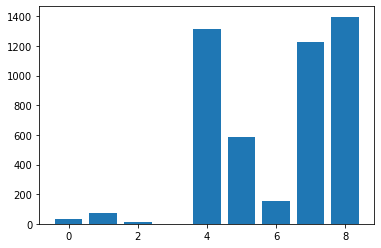

In [169]:
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [170]:
num_kbest = pd.DataFrame(fs.scores_, columns=['scores']).sort_values(
    ascending=False, by='scores').reset_index().rename(columns={'index':'features'})
num_kbest

,features,scores
0,8,1397.298094
1,4,1312.651487
2,7,1228.455657
3,5,583.512400
4,6,155.743507
5,1,76.221529
6,0,29.371084
7,2,10.009152
8,3,0.139565


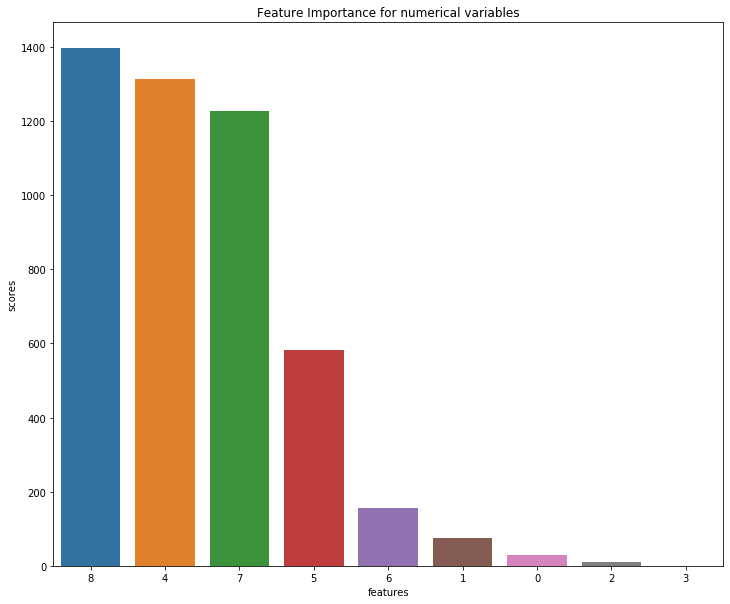

In [171]:
plt.subplots(figsize=(12,10))
sns.barplot(data=num_kbest, x='features', y='scores', order=num_kbest.features)
plt.title('Feature Importance for numerical variables')
plt.show()

> I would go with features that equals or above the average score

In [172]:
num_kbest_avg = num_kbest.scores.mean()
num_kbest_avg

532.6002751214006

In [173]:
num_kbest=num_kbest.query('scores >= @num_kbest_avg')
num_kbest

,features,scores
0,8,1397.298094
1,4,1312.651487
2,7,1228.455657
3,5,583.512400


> We have only 4 of such features

> about four features are most useful for our prediction, hence I will go for 4

In [175]:
# define feature selection, 
fs = SelectKBest(score_func=f_classif, k=4)
# apply feature selection
num_selected_kbest = fs.fit_transform(features_num, target)
print(num_selected_kbest.shape)

(37069, 4)


/home/patrick/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [176]:
num_selected_kbest

array([[ 1.1000e+00,  9.3994e+01,  4.8570e+00,  5.1910e+03],
       [ 1.1000e+00,  9.3994e+01,  4.8570e+00,  5.1910e+03],
       [ 1.1000e+00,  9.3994e+01,  4.8570e+00,  5.1910e+03],
       ...,
       [-1.1000e+00,  9.4199e+01,  8.7900e-01,  4.9636e+03],
       [-1.1000e+00,  9.4199e+01,  8.7900e-01,  4.9636e+03],
       [-1.1000e+00,  9.4199e+01,  8.8000e-01,  4.9636e+03]])

> 

#### Perform feature selection on categorical features

> I would take the same approach as the numerical vars on the cat vars

> But first, we have to encode our categorical variables using OneHotEncoding

In [130]:
fs_1 = SelectKBest(score_func=chi2, k='all')
fs_1.fit(features_cat_encode, target)

SelectKBest(k='all', score_func=<function chi2 at 0x7f4b7172cd08>)

In [144]:
for i in range(len(fs_1.scores_)):
	print('Feature %d: %f' % (i, fs_1.scores_[i]))

Feature 0: 19.192975
Feature 1: 34.827808
Feature 2: 0.018024
Feature 3: 7.261408
Feature 4: 0.083253
Feature 5: 18.868787
Feature 6: 1.304342
Feature 7: 8.612814
Feature 8: 123.288332
Feature 9: 0.659547
Feature 10: 0.955333
Feature 11: 0.378734
Feature 12: 4.252584
Feature 13: 18.278362
Feature 14: 58.276237
Feature 15: 0.718807
Feature 16: 21.536106
Feature 17: 5.026870
Feature 18: 12.689765
Feature 19: 0.075758
Feature 20: 0.673479
Feature 21: 1.251001
Feature 22: 53.961137
Feature 23: 0.017317
Feature 24: 32.217282
Feature 25: 110.170986
Feature 26: 0.249861
Feature 27: 0.781847
Feature 28: 2.640205
Feature 29: 1.381006
Feature 30: 0.185618
Feature 31: 2.640205
Feature 32: 0.124968
Feature 33: 137.652102
Feature 34: 216.844617
Feature 35: 316.272892
Feature 36: 5.248167
Feature 37: 85.660468
Feature 38: 5.860430
Feature 39: 4.459332
Feature 40: 701.230763
Feature 41: 86.622513
Feature 42: 22.644214
Feature 43: 285.549469
Feature 44: 67.422005
Feature 45: 0.937036
Feature 46: 3.076

In [152]:
cat_kbest = pd.DataFrame(fs_1.scores_, columns=['scores']).sort_values(
    ascending=False, by='scores').reset_index().rename(columns={'index':'features'})
cat_kbest.head(10)

,features,scores
0,40,701.230763
1,35,316.272892
2,43,285.549469
3,34,216.844617
4,33,137.652102
5,8,123.288332
6,25,110.170986
7,41,86.622513
8,37,85.660468
9,44,67.422005


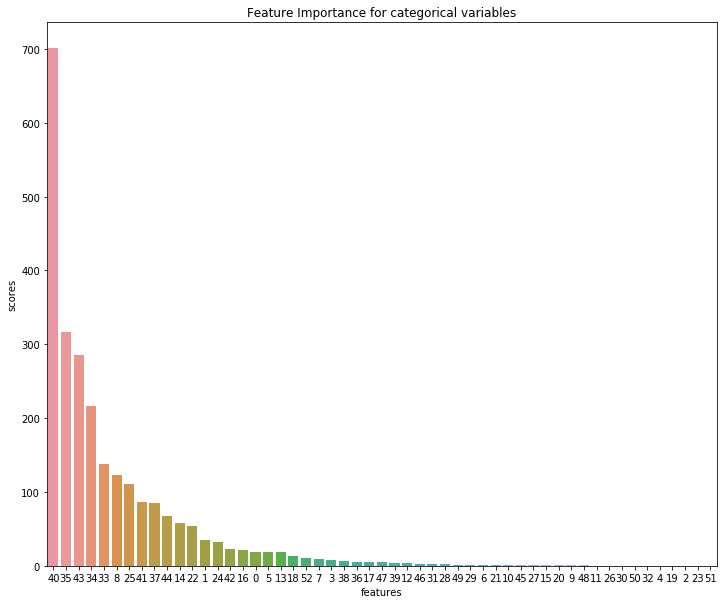

In [158]:
plt.subplots(figsize=(12,10))
sns.barplot(data=cat_kbest, x='features', y='scores', order=cat_kbest.features)
plt.title('Feature Importance for categorical variables')
plt.show()

> I would go with features that equals or above the average score

In [160]:
cat_kbest_avg = cat_kbest.scores.mean()
cat_kbest_avg

47.15224161403169

In [164]:
cat_kbest=cat_kbest.query('scores >= @cat_kbest_avg')
cat_kbest

,features,scores
0,40,701.230763
1,35,316.272892
2,43,285.549469
3,34,216.844617
4,33,137.652102
5,8,123.288332
6,25,110.170986
7,41,86.622513
8,37,85.660468
9,44,67.422005


> We have only 12 of such features

In [ ]:
> I would concatenate 

> encode categorical variables in features

> merge with train data

In [ ]:
for col in to